# Data Analysis for all combinations of n-substituents [6]Helicenes
This notebook provides a structured workflow to obtain all the predictions for halogenated [6]Helicenes from 1 up to 6 substituents, and up to 16 due to the computational cost will just predict 100 random molecules for each substituents.

# Check for GPU usage

In [1]:
import tensorflow as tf
# Check TensorFlow version for compatibility
print("TensorFlow version:", tf.__version__)
# List available GPUs for GPU acceleration
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    print("GPUs:", physical_devices)
    try:
        # Enable dynamic memory growth (best practice to avoid GPU memory errors)
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
    except Exception as e:
        pass
else:
    print("No GPU found, using CPU.")

TensorFlow version: 2.10.1
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Load data, our models and import libraries
Load x_data and y_data as well as OHE variables and stats like mean and std Rmax values from Load_manipulate notebook, as well as our model and it's upper and lower models aplications for obtaining the uncertainty intervals.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data from the CSV file
data_combined = pd.read_csv('OHE_data.csv')

# Separate x_data and y_data
x_data = data_combined.iloc[:, :-1].values  # All columns except the last one
y_data = data_combined['target'].values    # The last column

# Load trained and tested x_data and y_data
x_train = pd.read_csv('x_train.csv')
y_train = pd.read_csv('y_train.csv')
x_test = pd.read_csv('x_test.csv')
y_test = pd.read_csv('y_test.csv')

y_train = y_train.to_numpy().ravel()
y_test = y_test.to_numpy().ravel()

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)


# Helicene parameters
n_atom_types = 5          # e.g., 5 atom types (H, F, Cl, Br, I)
n_pos = 16                # number of possible positions (16)
n_features = n_atom_types * n_pos  # total one-hot features

# Load Rmax_abs_mean and Rmax_abs_std from the CSV file
stats = pd.read_csv('Rmax_stats.csv')
Rmax_abs_mean = stats['Rmax_abs_mean'].values[0]
Rmax_abs_std = stats['Rmax_abs_std'].values[0]

# Load the pre-trained model

model_path = './CV_Models/R_model_CV'
best_model = tf.keras.models.load_model(model_path)

print("Model loaded successfully!")

# Load the lower and upper quantile models
model_lower =  tf.keras.models.load_model('model_lower.h5', compile=False)
model_upper =  tf.keras.models.load_model('model_upper.h5', compile=False)

print("Quantile models loaded successfully!")


x_train shape: (946, 80)
y_train shape: (946,)
x_test shape: (237, 80)
y_test shape: (237,)
Model loaded successfully!
Quantile models loaded successfully!


# Data analysis from mono to hexa-halogenated [6]Helicenes

In [3]:
# Import combinatory library to generate combinations
from itertools import combinations, product, permutations

In [4]:
# Define the positions in the [6]Helicene molecule
positions = list(range(1, 17))  # Posiciones 1 a 16

# Define the halogens
halogens = ['F', 'Cl', 'Br', 'I']

In [5]:
from time import perf_counter

# ----------------------------
# Configuration
halogen_to_index = {'H': 0, 'F': 1, 'Cl': 2, 'Br': 3, 'I': 4}
BATCH_SIZE = 4096
# ----------------------------

# Fast one-hot encoder
def encode_batch(molecules):
    one_hot = np.zeros((len(molecules), n_pos * n_atom_types), dtype=np.float32)
    for i, mol in enumerate(molecules):
        for j, atom in enumerate(mol):
            idx = halogen_to_index[atom]
            one_hot[i, j * n_atom_types + idx] = 1.0
    return one_hot

# Molecule generator with symmetry filtering
def generate_unique_molecules(n_subs):
    visited = set()
    for pos_comb in combinations(positions, n_subs):
        for hal_comb in product(halogens, repeat=n_subs):
            mol = ['H'] * n_pos
            for pos, hal in zip(pos_comb, hal_comb):
                mol[pos - 1] = hal
            mol_tuple = tuple(mol)
            mol_rev = tuple(mol[::-1])
            if mol_rev in visited:
                continue
            visited.add(mol_tuple)
            yield mol

# Main predictor
def predict_rmax_substituted(n_subs, model, mean, std):
    print(f"\n Predicting {n_subs}-halogenated molecules...")
    start_total = perf_counter()

    predictions = []
    batch_raw = []
    batch_id = 0

    molecule_generator = generate_unique_molecules(n_subs)

    for mol in molecule_generator:
        batch_raw.append(mol)

        if len(batch_raw) == BATCH_SIZE:
            encoded = encode_batch(batch_raw)

            with tf.device('/GPU:0'):
                pred_norm = model.predict(encoded, verbose=0)

            pred = pred_norm * std + mean
            predictions.extend([(mol, val[0]) for mol, val in zip(batch_raw, pred)])

            if batch_id % 10 == 0:
                print(f"Batch {batch_id}: processed {len(predictions)} molecules")
            batch_raw.clear()
            batch_id += 1

    # Process leftover molecules
    if batch_raw:
        encoded = encode_batch(batch_raw)
        with tf.device('/GPU:0'):
            pred_norm = model.predict(encoded, verbose=0)
        pred = pred_norm * std + mean
        predictions.extend([(mol, val[0]) for mol, val in zip(batch_raw, pred)])
        batch_raw.clear()

    # Sort by predicted Rmax
    predictions.sort(key=lambda x: x[1], reverse=True)

    # Summary
    print(f"\nTop 10 {n_subs}-halogenated molecules:")
    for i, (mol, rmax) in enumerate(predictions[:10]):
        print(f"{i+1:2d}. Rmax = {rmax:.2f} → {mol}")

    print(f"\n Finished: {len(predictions)} molecules in {perf_counter() - start_total:.2f} s")

    return predictions


# Data analysis for Mono-halogenated [6]Helicene

In [6]:
# Function to generate unique substitutions with one halogen
def generate_unique_substitutions(positions, halogens):
    unique_substitutions = []
    for halogen in halogens:
        # Generate all combinations of one halogen substitution
        for pos in positions:
            # Create a molecule with all hydrogens
            molecule = ['H'] * len(positions)
            # Substitute the halogen at the specified position
            molecule[pos-1] = halogen
            # Add the molecule to the list if its reverse is not already included
            if molecule[::-1] not in unique_substitutions:
                unique_substitutions.append(molecule)
    return unique_substitutions

# Generate the unique substitutions
unique_substitutions = generate_unique_substitutions(positions, halogens)

# Print the results
print(f"Number of unique substitutions: {len(unique_substitutions)}")
for sub in unique_substitutions:
    print(sub)

# Function to encode a molecule into a one-hot vector
def encode_molecule(molecule, n_pos, n_atom_types):
    one_hot = np.zeros((1, n_pos * n_atom_types))
    atom_types = ['H', 'F', 'Cl', 'Br', 'I']
    for i, atom in enumerate(molecule):
        atom_index = atom_types.index(atom)
        one_hot[0, i * n_atom_types + atom_index] = 1.0
    return one_hot

# Predict Rmax for all molecules
mono_predictions = []
for molecule in unique_substitutions:
    encoded_molecule = encode_molecule(molecule, n_pos=16, n_atom_types=5)
    pred_normalized = best_model.predict(encoded_molecule).ravel()
    pred = pred_normalized * Rmax_abs_std + Rmax_abs_mean  # Denormalize
    mono_predictions.append((molecule, pred[0]))

# Mean Rmax value
mean_rmax = np.mean([pred[1] for pred in mono_predictions])
print(f"Mean Rmax value for all mono-halogenated molecules: {mean_rmax:.2f}")

# Sort predictions by Rmax value in descending order
mono_predictions.sort(key=lambda x: x[1], reverse=True)

# Print the top 10 molecules with the highest Rmax values
print("\nTop 10 Mono-halogenated Molecules with Highest Rmax Values:")
for i, (molecule, rmax) in enumerate(mono_predictions[:10]):
    print(f"Rank {i + 1}: Rmax = {rmax:.2f}")
    print(f"Molecule: {molecule}")
    print("-" * 50)

Number of unique substitutions: 32
['F', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
['H', 'F', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
['H', 'H', 'F', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
['H', 'H', 'H', 'F', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
['H', 'H', 'H', 'H', 'F', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
['H', 'H', 'H', 'H', 'H', 'F', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
['H', 'H', 'H', 'H', 'H', 'H', 'F', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
['H', 'H', 'H', 'H', 'H', 'H', 'H', 'F', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
['Cl', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
['H', 'Cl', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
['H', 'H', 'Cl', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
['H', 'H', 'H', 'Cl', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H',

# Location of Halogens in Monohalogenated [6]Helicenes

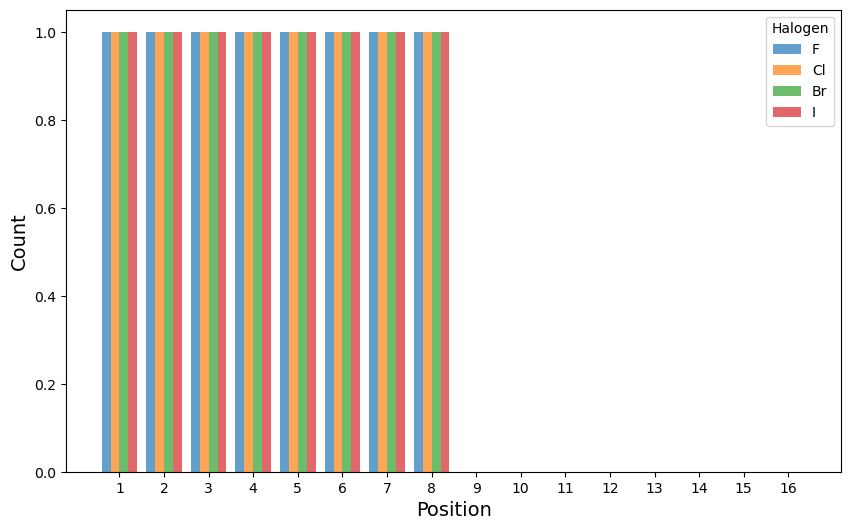

In [7]:
# Initialize a dictionary to count halogen occurrences at each position
halogen_counts = {halogen: [0] * len(positions) for halogen in halogens}

# Count occurrences of each halogen at each position
for molecule, _ in mono_predictions:  # Use predictions from the monohalogenated case
    for pos, atom in enumerate(molecule):
        if atom in halogens:
            halogen_counts[atom][pos] += 1
            
# Plot the results
plt.figure(figsize=(10, 6))

# Define the width of each bar and the offset for each halogen
bar_width = 0.2
offsets = [-1.5 * bar_width, -0.5 * bar_width, 0.5 * bar_width, 1.5 * bar_width]  # Adjust offsets for 4 halogens

# Plot each halogen's counts with a unique color and offset
for i, (halogen, counts) in enumerate(halogen_counts.items()):
    plt.bar(
        [pos + offsets[i] for pos in positions],  # Offset positions for each halogen
        counts,
        width=bar_width,
        label=halogen,
        alpha=0.7
    )

plt.xlabel("Position", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(positions)  # Ensure the x-axis ticks align with positions
plt.legend(title="Halogen")
plt.grid(False)
plt.show()

# ΔR_max by Position for Monohalogenated [6]Helicene

1/1 [==============================] - 0s 15ms/step


C:\Users\AlejandroN01\AppData\Local\Temp\ipykernel_253464\2599021787.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rmax_H = float(best_model.predict(encoded_H)[0])


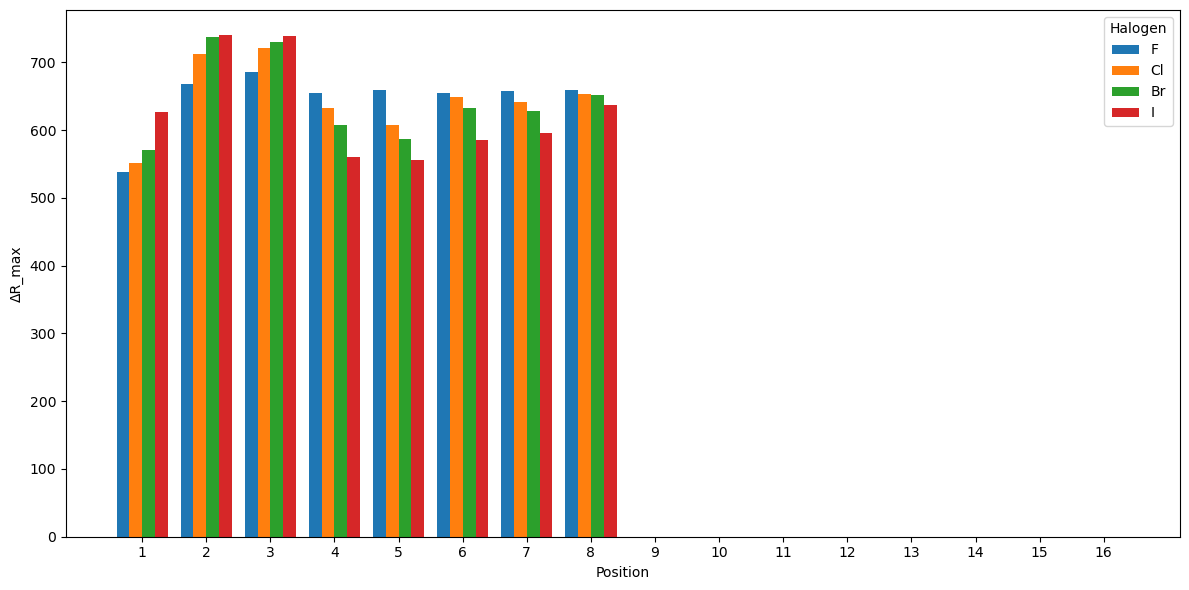

In [8]:
# Define the positions in the [6]Helicene molecule as an array
positions_array = np.arange(1, 17)  # Positions 1 to 16

# Step 1: Get Rmax for the all-H molecule
base_subs = ['H'] * 16
encoded_H = encode_molecule(base_subs, n_pos=16, n_atom_types=5)
rmax_H = float(best_model.predict(encoded_H)[0])

# Step 2: Build ΔRmax by position per halogen from existing mono_predictions
delta_rmax = {hal: [0.0] * 16 for hal in halogens}

for molecule, rmax in mono_predictions:
    # Find the substituted position and the halogen used
    for idx, atom in enumerate(molecule):
        if atom in halogens:
            pos = idx  # 0-based index
            hal = atom
            break
    delta = rmax - rmax_H
    delta_rmax[hal][pos] = delta

# Step 3: Plotting
bar_width = 0.2
offsets = [-1.5, -0.5, 0.5, 1.5]

fig, ax = plt.subplots(figsize=(12, 6))

for i, hal in enumerate(halogens):
    pos_shifted = positions_array + offsets[i] * bar_width
    ax.bar(pos_shifted, delta_rmax[hal], width=bar_width, label=hal)

ax.set_xticks(positions_array)
ax.set_xticklabels(positions_array)
ax.set_xlabel('Position')
ax.set_ylabel('ΔR_max')
ax.legend(title='Halogen')
plt.tight_layout()
plt.show()


# Prediction of the TOP 10 using encode_batch
For low number of molecules to predict is more suitable to dont use batch since it can make poor generalizations since it's predicting many molecules at one instead of going one by one.

In [9]:
mono_predictions = predict_rmax_substituted(
    n_subs=1,
    model=best_model,
    mean=Rmax_abs_mean,
    std=Rmax_abs_std
)


 Predicting 1-halogenated molecules...

Top 10 1-halogenated molecules:
 1. Rmax = 741.68 → ['H', 'I', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
 2. Rmax = 739.75 → ['H', 'H', 'I', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
 3. Rmax = 738.51 → ['H', 'Br', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
 4. Rmax = 731.93 → ['H', 'H', 'Br', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
 5. Rmax = 722.86 → ['H', 'H', 'Cl', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
 6. Rmax = 713.87 → ['H', 'Cl', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
 7. Rmax = 686.76 → ['H', 'H', 'F', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
 8. Rmax = 670.20 → ['H', 'F', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
 9. Rmax = 660.09 → ['H', 'H', 'H', 'H', 'F', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
10. Rmax = 659

# Data analysis for Di-halogenated [6]Helicene

# Prediction of the TOP 10 using encode_batch
Now we have 976 molecules. Still a low number to use batches.

In [10]:
BATCH_SIZE = 32
di_predictions = predict_rmax_substituted(
    n_subs=2,
    model=best_model,
    mean=Rmax_abs_mean,
    std=Rmax_abs_std
)


 Predicting 2-halogenated molecules...
Batch 0: processed 32 molecules
Batch 10: processed 352 molecules
Batch 20: processed 672 molecules

Top 10 2-halogenated molecules:
 1. Rmax = 802.91 → ['H', 'H', 'I', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'I', 'H', 'H']
 2. Rmax = 795.90 → ['H', 'H', 'Br', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'I', 'H', 'H']
 3. Rmax = 788.90 → ['H', 'H', 'Br', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'Br', 'H', 'H']
 4. Rmax = 787.24 → ['H', 'H', 'Cl', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'I', 'H', 'H']
 5. Rmax = 786.34 → ['H', 'I', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'I', 'H']
 6. Rmax = 784.52 → ['H', 'Br', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'I', 'H']
 7. Rmax = 782.54 → ['H', 'Br', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'Br', 'H']
 8. Rmax = 780.19 → ['H', 'H', 'Cl', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'Br', 'H', 'H']
 9. Rmax =

# Individual predictions
Predictions without batches to prevent poor generalization since we only have 976 molecules.

In [11]:
# Generate unique di-halogenated molecules
unique_patterns = set()
for pos_pair in combinations(positions, 2):  # Choose 2 positions from 16
    for hal_pair in product(halogens, repeat=2):  # All combinations of 2 halogens
        # Create a molecule with all hydrogens
        molecule = ['H'] * len(positions)
        # Place the halogens at the specified positions
        molecule[pos_pair[0] - 1] = hal_pair[0]  # Adjust for 0-based indexing
        molecule[pos_pair[1] - 1] = hal_pair[1]
        # Add the molecule to the set if its reverse is not already included
        if tuple(molecule[::-1]) not in unique_patterns:  # Convert reversed list to tuple
            unique_patterns.add(tuple(molecule))  # Convert molecule to tuple for immutability

# Output
print(f"Total unique di-halogenated molecules: {len(unique_patterns)}")
print("Examples:")
for i, molecule in enumerate(sorted(unique_patterns)[:5]):  # Show first 5 examples
    print(f"{i + 1}: {list(molecule)}")  # Convert tuple back to list for display
    
# Predict Rmax for all molecules
di_predictions = []
for molecule in unique_patterns:
    encoded_molecule = encode_molecule(list(molecule), n_pos=16, n_atom_types=5)  # Convert tuple back to list
    pred_normalized = best_model.predict(encoded_molecule).ravel()
    pred = pred_normalized * Rmax_abs_std + Rmax_abs_mean  # Denormalize
    di_predictions.append((list(molecule), pred[0]))

# Sort predictions by Rmax value in descending order
di_predictions.sort(key=lambda x: x[1], reverse=True)

# Mean Rmax value of top 100 highest Rmax values
mean_rmax_100 = np.mean([pred[1] for pred in di_predictions[:100]])
print(f"Mean Rmax value for top 100 di-halogenated molecules: {mean_rmax_100:.2f}")

# Print the top 10 molecules with the highest Rmax values
print("\nTop 10 Di-halogenated Molecules with Highest Rmax Values:")
for i, (molecule, rmax) in enumerate(di_predictions[:10]):
    print(f"Rank {i + 1}: Rmax = {rmax:.2f}")
    print(f"Molecule: {molecule}")
    print("-" * 50)

Total unique di-halogenated molecules: 976
Examples:
1: ['Br', 'Br', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
2: ['Br', 'Cl', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
3: ['Br', 'F', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
4: ['Br', 'H', 'Br', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
5: ['Br', 'H', 'Cl', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
1/1 [==============================] - 0s 17ms/step
Mean Rmax value for top 100 di-halogenated molecules: 733.35

Top 10 Di-halogenated Molecules with Highest Rmax Values:
Rank 1: Rmax = 802.91
Molecule: ['H', 'H', 'I', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'I', 'H', 'H']
--------------------------------------------------
Rank 2: Rmax = 795.91
Molecule: ['H', 'H', 'Br', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'I', 'H', 'H']
--------------------------------------------------
Rank 3: Rmax = 78

# Predictions with Rmax higher than 700
This conditional is made to then visualize in a plot the positions tendecy of dihalogenated molecules. Batch is used just to make it quick since we have done to predictions before of the same thing for the sake of the analysis for a better and quicker predicting function.

In [12]:
# Track mirrored molecules
visited_patterns = set()

# Good candidates
good_candidates = []

# Batch buffer
batch_molecules = []
batch_raw_molecules = []

BATCH_SIZE = 32

for pos_duplet in combinations(positions, 2):
    for hal_duplet in product(halogens, repeat=2):
        molecule = ['H'] * len(positions)
        for pos, hal in zip(pos_duplet, hal_duplet):
            molecule[pos - 1] = hal
        
        mol_tuple = tuple(molecule)
        mol_rev = tuple(molecule[::-1])

        visited_patterns.add(mol_tuple)

        encoded = encode_molecule(molecule, n_pos=16, n_atom_types=5)
        batch_molecules.append(encoded) 
        batch_raw_molecules.append(list(molecule)) 

        if len(batch_molecules) == BATCH_SIZE:
            batch_array = np.vstack(batch_molecules)
            batch_pred_normalized = best_model.predict(batch_array)
            batch_pred = batch_pred_normalized * Rmax_abs_std + Rmax_abs_mean

            for mol, pred in zip(batch_raw_molecules, batch_pred):
                if pred[0] >= 700:
                    good_candidates.append((mol, pred[0]))

            batch_molecules.clear()
            batch_raw_molecules.clear()

# Process leftovers
if batch_molecules:
    batch_array = np.vstack(batch_molecules)
    batch_pred_normalized = best_model.predict(batch_array)
    batch_pred = batch_pred_normalized * Rmax_abs_std + Rmax_abs_mean

    for mol, pred in zip(batch_raw_molecules, batch_pred):
        if pred[0] >= 700:
            good_candidates.append(list(mol,pred[0]))

# Sort results
good_candidates.sort(key=lambda x: x[1], reverse=True)

print(f"\nTotal molecules with Rmax >= 700: {len(good_candidates)}")


1/1 [==============================] - 0s 12ms/step

Total molecules with Rmax >= 700: 252


# Location of Halogens in Dihalogenated [6]Helicenes

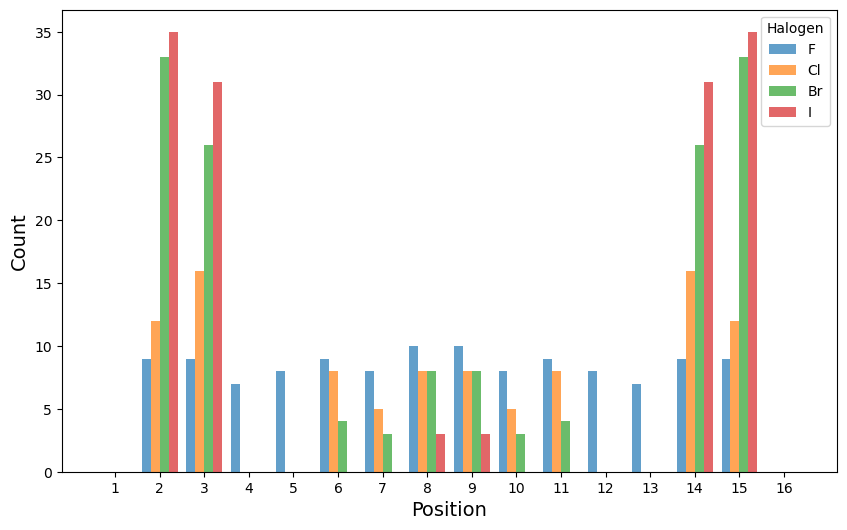

In [13]:
# Count the occurrences of each halogen at each position
halogen_counts = {halogen: [0] * len(positions) for halogen in halogens}
for molecule, _ in good_candidates:  # Unpack the tuple
    for pos, atom in enumerate(molecule):
        if atom in halogens:
            halogen_counts[atom][pos] += 1

# Plot the results
plt.figure(figsize=(10, 6))
bar_width = 0.2
offsets = [-1.5 * bar_width, -0.5 * bar_width, 0.5 * bar_width, 1.5 * bar_width]  # For 4 halogens

for i, (halogen, counts) in enumerate(halogen_counts.items()):
    plt.bar(
        [pos + offsets[i] for pos in range(len(positions))],
        counts,
        width=bar_width,
        label=halogen,
        alpha=0.7
    )

plt.xlabel("Position", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(range(len(positions)), [str(p) for p in positions])
plt.legend(title="Halogen")
plt.grid(False)
plt.show()

# ΔR_max by Position for Dihalogenated [6]Helicene

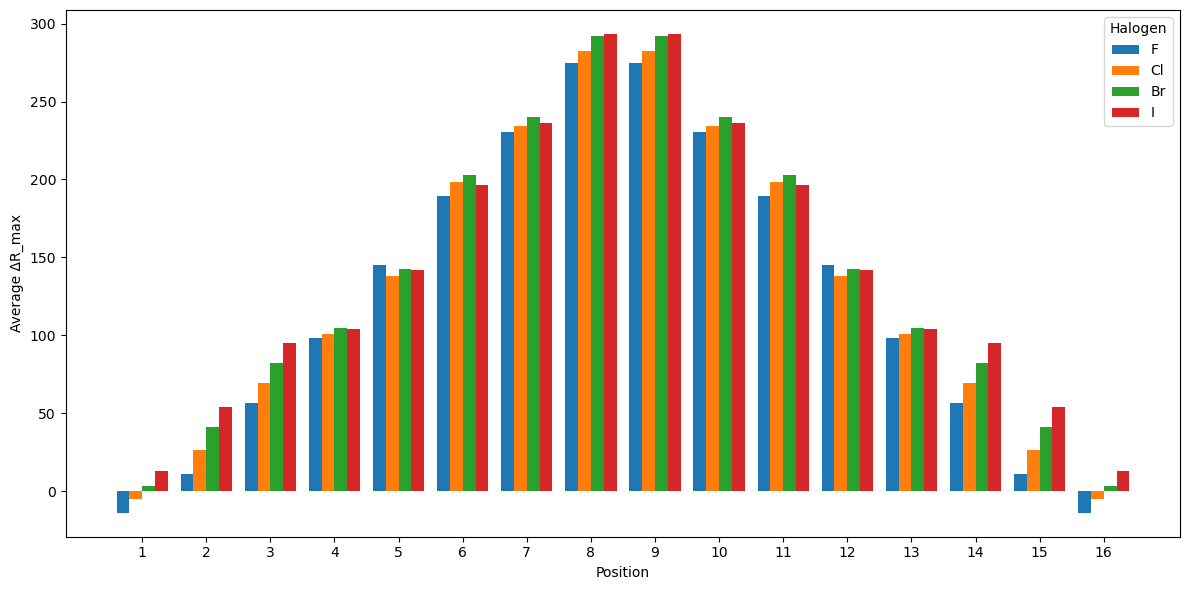

In [14]:
# Reuse predictions
mono_rmax = {tuple(molecule): rmax for molecule, rmax in mono_predictions}
di_rmax = {tuple(molecule): rmax for molecule, rmax in di_predictions}

# Initialize accumulators
delta_rmax_dihalogenated = {hal: [0.0] * 16 for hal in halogens}
count_deltas = {hal: [0] * 16 for hal in halogens}

# Step 1: Accumulate ΔR_max from dihalogenated molecules
for molecule, rmax_di in di_rmax.items():
    halogens_in_molecule = [(pos, atom) for pos, atom in enumerate(molecule) if atom in halogens]
    if len(halogens_in_molecule) != 2:
        continue

    (pos_i, hal_i), (pos_j, hal_j) = halogens_in_molecule

    mono_i = list(molecule)
    mono_i[pos_j] = 'H'
    mono_j = list(molecule)
    mono_j[pos_i] = 'H'

    rmax_mono_i = mono_rmax.get(tuple(mono_i), 0)
    rmax_mono_j = mono_rmax.get(tuple(mono_j), 0)

    delta_i = rmax_di - rmax_mono_i
    delta_j = rmax_di - rmax_mono_j

    delta_rmax_dihalogenated[hal_i][pos_i] += delta_i
    delta_rmax_dihalogenated[hal_j][pos_j] += delta_j
    count_deltas[hal_i][pos_i] += 1
    count_deltas[hal_j][pos_j] += 1

# Step 2: Compute symmetric-averaged ΔR_max
for hal in halogens:
    for i in range(8):  # 0 to 7
        j = 15 - i  # Mirror position
        # Combine values and counts
        total_delta = delta_rmax_dihalogenated[hal][i] + delta_rmax_dihalogenated[hal][j]
        total_count = count_deltas[hal][i] + count_deltas[hal][j]
        # Avoid division by zero
        avg = total_delta / total_count if total_count > 0 else 0.0
        # Assign symmetric average to both positions
        delta_rmax_dihalogenated[hal][i] = avg
        delta_rmax_dihalogenated[hal][j] = avg

# Step 3: Plotting
positions_array = np.arange(16)
bar_width = 0.2
offsets = [-1.5, -0.5, 0.5, 1.5]

fig, ax = plt.subplots(figsize=(12, 6))

for i, hal in enumerate(halogens):
    pos_shifted = positions_array + offsets[i] * bar_width
    ax.bar(pos_shifted, delta_rmax_dihalogenated[hal], width=bar_width, label=hal)

ax.set_xticks(positions_array)
ax.set_xticklabels(positions_array + 1)
ax.set_xlabel('Position')
ax.set_ylabel('Average ΔR_max')
ax.legend(title='Halogen')
plt.tight_layout()
plt.show()


# Data analysis for Tri-halogenated [6]Helicene

# Predictions with Rmax higher than 700

In [15]:
# Track mirrored molecules
visited_patterns = set()

# Good candidates
good_candidates = []

# Batch buffer
batch_molecules = []
batch_raw_molecules = []

BATCH_SIZE = 512

for pos_triplet in combinations(positions, 3):
    for hal_triplet in product(halogens, repeat=3):
        molecule = ['H'] * len(positions)
        for pos, hal in zip(pos_triplet, hal_triplet):
            molecule[pos - 1] = hal
        
        mol_tuple = tuple(molecule)
        mol_rev = tuple(molecule[::-1])

        visited_patterns.add(mol_tuple)

        encoded = encode_molecule(molecule, n_pos=16, n_atom_types=5)
        batch_molecules.append(encoded) 
        batch_raw_molecules.append(list(molecule)) 

        if len(batch_molecules) == BATCH_SIZE:
            batch_array = np.vstack(batch_molecules)
            batch_pred_normalized = best_model.predict(batch_array)
            batch_pred = batch_pred_normalized * Rmax_abs_std + Rmax_abs_mean

            for mol, pred in zip(batch_raw_molecules, batch_pred):
                if pred[0] >= 700:
                    good_candidates.append((mol, pred[0]))

            batch_molecules.clear()
            batch_raw_molecules.clear()

# Process leftovers
if batch_molecules:
    batch_array = np.vstack(batch_molecules)
    batch_pred_normalized = best_model.predict(batch_array)
    batch_pred = batch_pred_normalized * Rmax_abs_std + Rmax_abs_mean

    for mol, pred in zip(batch_raw_molecules, batch_pred):
        if pred[0] >= 700:
            good_candidates.append(list(mol,pred[0]))

# Sort results
good_candidates.sort(key=lambda x: x[1], reverse=True)

# Print top 10
print("\nTop 10 Tri-halogenated Molecules with Highest Rmax Values (Rmax >= 700):")
for i, (molecule, rmax) in enumerate(good_candidates[:10]):
    print(f"Rank {i + 1}: Rmax = {rmax:.2f}")
    print(f"Molecule: {molecule}")
    print("-" * 50)

print(f"\nTotal molecules with Rmax >= 700: {len(good_candidates)}")


16/16 [==============================] - 0s 2ms/step

Top 10 Tri-halogenated Molecules with Highest Rmax Values (Rmax >= 700):
Rank 1: Rmax = 804.57
Molecule: ['H', 'Cl', 'I', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'I', 'H', 'H']
--------------------------------------------------
Rank 2: Rmax = 804.57
Molecule: ['H', 'H', 'I', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'I', 'Cl', 'H']
--------------------------------------------------
Rank 3: Rmax = 801.75
Molecule: ['H', 'Br', 'I', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'I', 'H', 'H']
--------------------------------------------------
Rank 4: Rmax = 801.75
Molecule: ['H', 'H', 'I', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'I', 'Br', 'H']
--------------------------------------------------
Rank 5: Rmax = 801.25
Molecule: ['H', 'I', 'I', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'I', 'H', 'H']
--------------------------------------------------
Rank 6: Rmax = 801.25
Molecule: ['H', 'H', 'I', '

# Location of Halogens in Trihalogenated [6]Helicenes

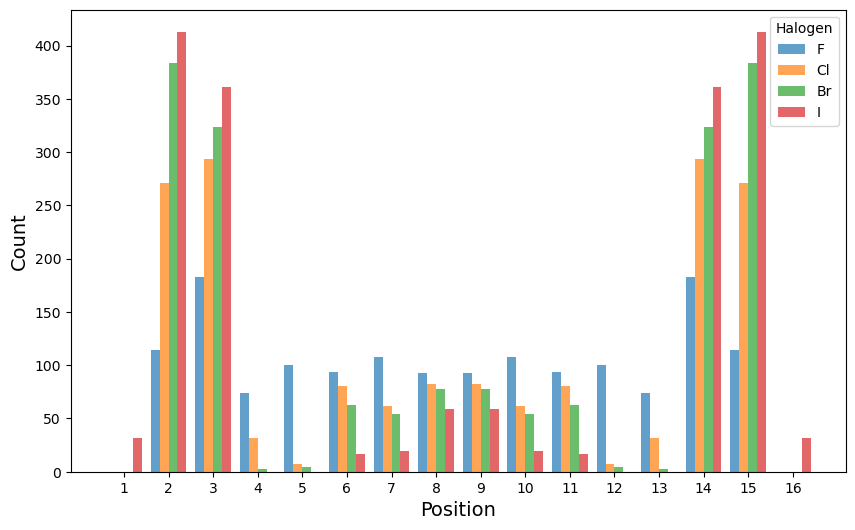

In [16]:
# Count the occurrences of each halogen at each position
halogen_counts = {halogen: [0] * len(positions) for halogen in halogens}
for molecule, _ in good_candidates:  # Unpack the tuple
    for pos, atom in enumerate(molecule):
        if atom in halogens:
            halogen_counts[atom][pos] += 1

# Plot the results
plt.figure(figsize=(10, 6))
bar_width = 0.2
offsets = [-1.5 * bar_width, -0.5 * bar_width, 0.5 * bar_width, 1.5 * bar_width]  # For 4 halogens

for i, (halogen, counts) in enumerate(halogen_counts.items()):
    plt.bar(
        [pos + offsets[i] for pos in range(len(positions))],
        counts,
        width=bar_width,
        label=halogen,
        alpha=0.7
    )

plt.xlabel("Position", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(range(len(positions)), [str(p) for p in positions])
plt.legend(title="Halogen")
plt.grid(False)
plt.show()

# Prediction of the TOP 10 using encode_batch
Now we have 17920 molecules. So we can use a batch to make it a bit faster without loosing generalization.

In [17]:
BATCH_SIZE = 128
tri_predictions = predict_rmax_substituted(
    n_subs=3,
    model=best_model,
    mean=Rmax_abs_mean,
    std=Rmax_abs_std
)


 Predicting 3-halogenated molecules...
Batch 0: processed 128 molecules
Batch 10: processed 1408 molecules
Batch 20: processed 2688 molecules
Batch 30: processed 3968 molecules
Batch 40: processed 5248 molecules
Batch 50: processed 6528 molecules
Batch 60: processed 7808 molecules
Batch 70: processed 9088 molecules
Batch 80: processed 10368 molecules
Batch 90: processed 11648 molecules
Batch 100: processed 12928 molecules
Batch 110: processed 14208 molecules
Batch 120: processed 15488 molecules
Batch 130: processed 16768 molecules

Top 10 3-halogenated molecules:
 1. Rmax = 804.57 → ['H', 'Cl', 'I', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'I', 'H', 'H']
 2. Rmax = 801.75 → ['H', 'Br', 'I', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'I', 'H', 'H']
 3. Rmax = 801.25 → ['H', 'I', 'I', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'I', 'H', 'H']
 4. Rmax = 800.39 → ['H', 'F', 'I', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'I', 'H', 'H']
 5. Rmax = 799.05 → ['H

# ΔR_max by Position for Trihalogenated [6]Helicene (vs Dihalogenated)

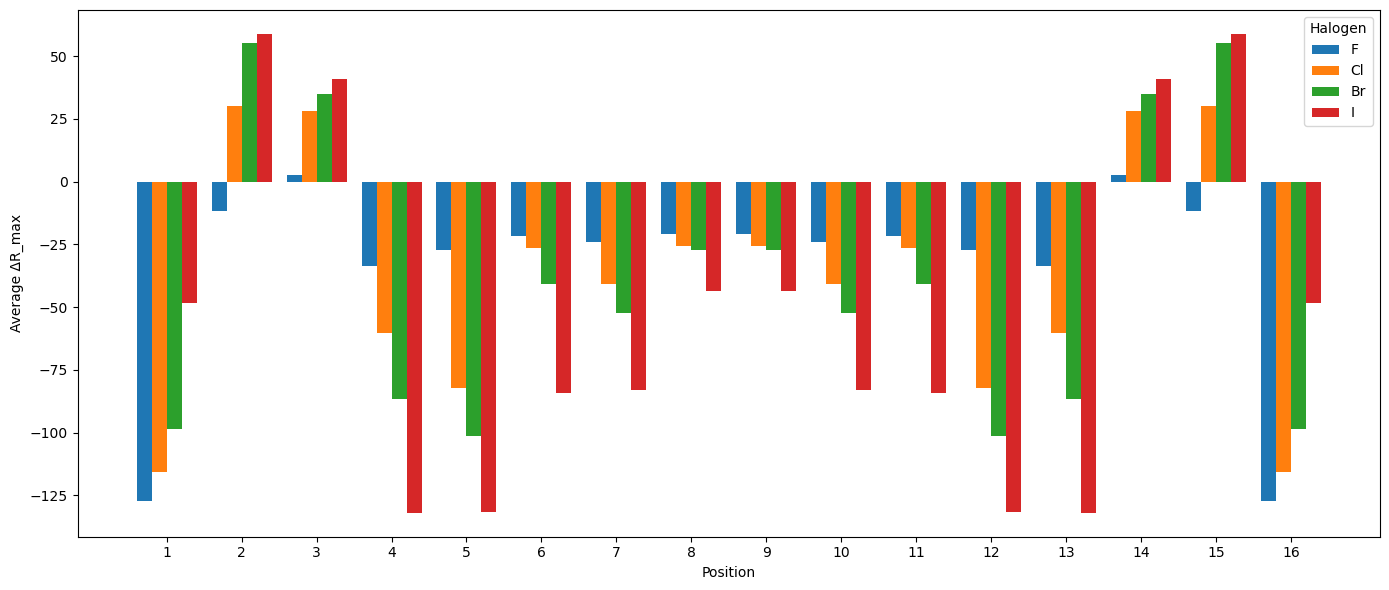

In [18]:
# Step 0: Prepare dictionaries from previous predictions
di_rmax = {tuple(molecule): rmax for molecule, rmax in di_predictions}
tri_rmax = {tuple(molecule): rmax for molecule, rmax in tri_predictions}

# Initialize accumulators
delta_rmax_trihalogenated = {hal: [0.0] * 16 for hal in halogens}
count_deltas = {hal: [0] * 16 for hal in halogens}

# Step 1: Accumulate ΔR_max from trihalogenated vs dihalogenated
for molecule, rmax_tri in tri_rmax.items():
    # Find halogen positions
    halogens_in_molecule = [(pos, atom) for pos, atom in enumerate(molecule) if atom in halogens]
    if len(halogens_in_molecule) != 3:
        continue  # Skip invalid entries

    # For each of the three dihalogenated variants (remove one halogen)
    for idx in range(3):
        (pos_removed, hal_removed) = halogens_in_molecule[idx]
        di_molecule = list(molecule)
        di_molecule[pos_removed] = 'H'

        rmax_di = di_rmax.get(tuple(di_molecule), None)
        if rmax_di is None:
            continue  # Skip if corresponding dihalogenated molecule is missing

        delta = rmax_tri - rmax_di
        delta_rmax_trihalogenated[hal_removed][pos_removed] += delta
        count_deltas[hal_removed][pos_removed] += 1

# Step 2: Enforce symmetry (mirror-averaged values)
for hal in halogens:
    for i in range(8):
        j = 15 - i  # Mirror position
        total_delta = delta_rmax_trihalogenated[hal][i] + delta_rmax_trihalogenated[hal][j]
        total_count = count_deltas[hal][i] + count_deltas[hal][j]
        avg = total_delta / total_count if total_count > 0 else 0.0
        delta_rmax_trihalogenated[hal][i] = avg
        delta_rmax_trihalogenated[hal][j] = avg

# Step 3: Plotting
positions_array = np.arange(16)
bar_width = 0.2
offsets = [-1.5, -0.5, 0.5, 1.5]

fig, ax = plt.subplots(figsize=(14, 6))

for i, hal in enumerate(halogens):
    pos_shifted = positions_array + offsets[i] * bar_width
    ax.bar(pos_shifted, delta_rmax_trihalogenated[hal], width=bar_width, label=hal)

ax.set_xticks(positions_array)
ax.set_xticklabels(positions_array + 1)
ax.set_xlabel('Position')
ax.set_ylabel('Average ΔR_max')
ax.legend(title='Halogen')
plt.tight_layout()
plt.show()


# Data analysis for tetra-halogenated [6]Helicenes

# Predictions with Rmax higher than 700

In [19]:
# Track mirrored molecules
visited_patterns = set()

# Good candidates
good_candidates = []

# Batch buffer
batch_molecules = []
batch_raw_molecules = []

BATCH_SIZE = 512

for pos_quad in combinations(positions, 4):
    for hal_quad in product(halogens, repeat=4):
        molecule = ['H'] * len(positions)
        for pos, hal in zip(pos_quad, hal_quad):
            molecule[pos - 1] = hal
        
        mol_tuple = tuple(molecule)
        mol_rev = tuple(molecule[::-1])

        visited_patterns.add(mol_tuple)

        encoded = encode_molecule(molecule, n_pos=16, n_atom_types=5)
        batch_molecules.append(encoded) 
        batch_raw_molecules.append(list(molecule)) 

        if len(batch_molecules) == BATCH_SIZE:
            batch_array = np.vstack(batch_molecules)
            batch_pred_normalized = best_model.predict(batch_array)
            batch_pred = batch_pred_normalized * Rmax_abs_std + Rmax_abs_mean

            for mol, pred in zip(batch_raw_molecules, batch_pred):
                if pred[0] >= 790:
                    good_candidates.append((mol, pred[0]))

            batch_molecules.clear()
            batch_raw_molecules.clear()

# Process leftovers
if batch_molecules:
    batch_array = np.vstack(batch_molecules)
    batch_pred_normalized = best_model.predict(batch_array)
    batch_pred = batch_pred_normalized * Rmax_abs_std + Rmax_abs_mean

    for mol, pred in zip(batch_raw_molecules, batch_pred):
        if pred[0] >= 790:
            good_candidates.append(list(mol,pred[0]))

# Sort results
good_candidates.sort(key=lambda x: x[1], reverse=True)

# Print top 10
print("\nTop 10 Tetra-halogenated Molecules with Highest Rmax Values (Rmax >= 800):")
for i, (molecule, rmax) in enumerate(good_candidates[:10]):
    print(f"Rank {i + 1}: Rmax = {rmax:.2f}")
    print(f"Molecule: {molecule}")
    print("-" * 50)

print(f"\nTotal molecules with Rmax >= 790: {len(good_candidates)}")


16/16 [==============================] - 0s 2ms/step

Top 10 Tetra-halogenated Molecules with Highest Rmax Values (Rmax >= 800):
Rank 1: Rmax = 803.55
Molecule: ['H', 'Cl', 'I', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'I', 'Cl', 'H']
--------------------------------------------------
Rank 2: Rmax = 803.48
Molecule: ['H', 'F', 'I', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'I', 'Cl', 'H']
--------------------------------------------------
Rank 3: Rmax = 803.48
Molecule: ['H', 'Cl', 'I', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'I', 'F', 'H']
--------------------------------------------------
Rank 4: Rmax = 801.23
Molecule: ['H', 'Cl', 'I', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'I', 'Br', 'H']
--------------------------------------------------
Rank 5: Rmax = 801.23
Molecule: ['H', 'Br', 'I', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'I', 'Cl', 'H']
--------------------------------------------------
Rank 6: Rmax = 800.91
Molecule: ['H', 'F', 

# Location of Halogens in Tetrahalogenated [6]Helicenes

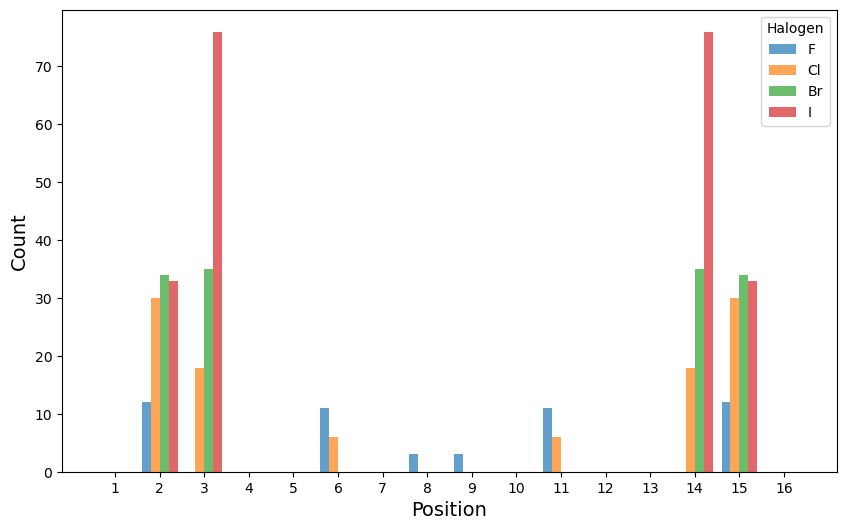

In [20]:
# Count the occurrences of each halogen at each position
halogen_counts = {halogen: [0] * len(positions) for halogen in halogens}
for molecule, _ in good_candidates:  # Unpack the tuple
    for pos, atom in enumerate(molecule):
        if atom in halogens:
            halogen_counts[atom][pos] += 1

# Plot the results
plt.figure(figsize=(10, 6))
bar_width = 0.2
offsets = [-1.5 * bar_width, -0.5 * bar_width, 0.5 * bar_width, 1.5 * bar_width]  # For 4 halogens

for i, (halogen, counts) in enumerate(halogen_counts.items()):
    plt.bar(
        [pos + offsets[i] for pos in range(len(positions))],
        counts,
        width=bar_width,
        label=halogen,
        alpha=0.7
    )

plt.xlabel("Position", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(range(len(positions)), [str(p) for p in positions])
plt.legend(title="Halogen")
plt.grid(False)
plt.show()

# Prediction of the TOP 10 using encode_batch
Now we have 233184 molecules. So we can use a batch to make it faster without loosing generalization.

In [21]:
BATCH_SIZE = 512
tetra_predictions = predict_rmax_substituted(
    n_subs=4,
    model=best_model,
    mean=Rmax_abs_mean,
    std=Rmax_abs_std
)


 Predicting 4-halogenated molecules...
Batch 0: processed 512 molecules
Batch 10: processed 5632 molecules
Batch 20: processed 10752 molecules
Batch 30: processed 15872 molecules
Batch 40: processed 20992 molecules
Batch 50: processed 26112 molecules
Batch 60: processed 31232 molecules
Batch 70: processed 36352 molecules
Batch 80: processed 41472 molecules
Batch 90: processed 46592 molecules
Batch 100: processed 51712 molecules
Batch 110: processed 56832 molecules
Batch 120: processed 61952 molecules
Batch 130: processed 67072 molecules
Batch 140: processed 72192 molecules
Batch 150: processed 77312 molecules
Batch 160: processed 82432 molecules
Batch 170: processed 87552 molecules
Batch 180: processed 92672 molecules
Batch 190: processed 97792 molecules
Batch 200: processed 102912 molecules
Batch 210: processed 108032 molecules
Batch 220: processed 113152 molecules
Batch 230: processed 118272 molecules
Batch 240: processed 123392 molecules
Batch 250: processed 128512 molecules
Batch 

# ΔR_max by Position for Tetrahalogenated [6]Helicene (vs Trihalogenated)

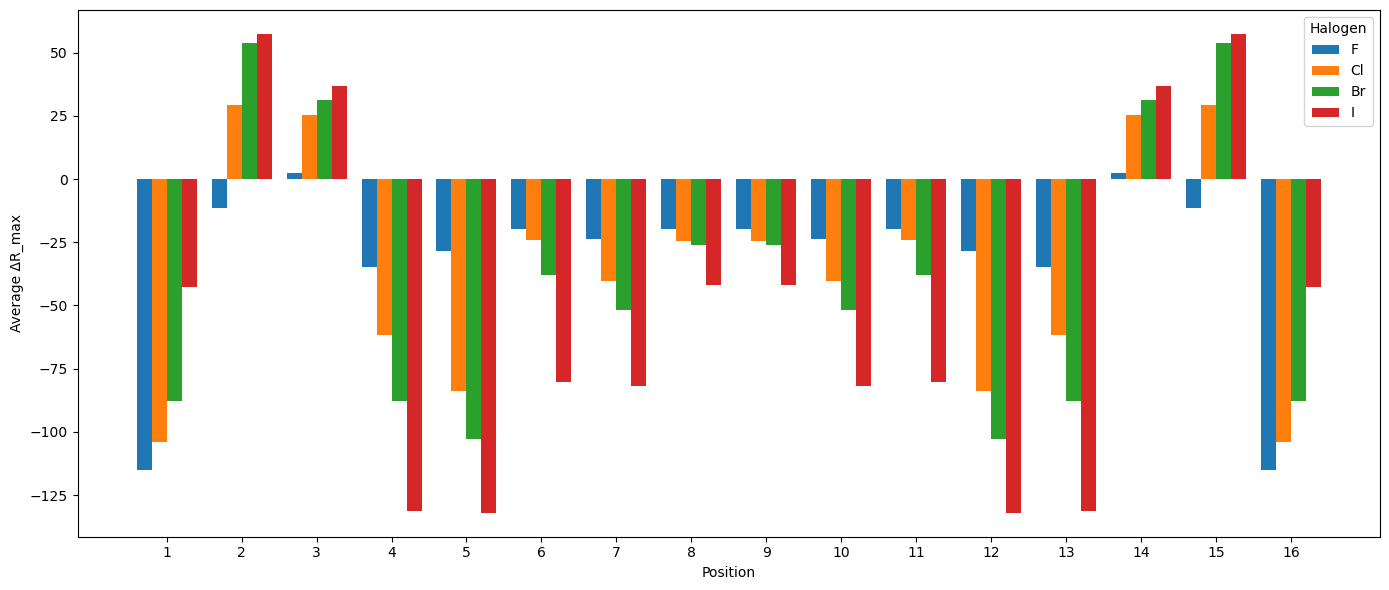

In [22]:
# Step 0: Prepare prediction dictionaries
tri_rmax = {tuple(molecule): rmax for molecule, rmax in tri_predictions}
tetra_rmax = {tuple(molecule): rmax for molecule, rmax in tetra_predictions}

# Initialize accumulators
delta_rmax_tetrahalogenated = {hal: [0.0] * 16 for hal in halogens}
count_deltas = {hal: [0] * 16 for hal in halogens}

# Step 1: Accumulate ΔRmax by comparing tetra- vs tri-halogenated molecules
for molecule, rmax_tetra in tetra_rmax.items():
    halogens_in_molecule = [(pos, atom) for pos, atom in enumerate(molecule) if atom in halogens]
    if len(halogens_in_molecule) != 4:
        continue

    # Generate each tri-halogenated version (remove one halogen at a time)
    for idx in range(4):
        pos_removed, hal_removed = halogens_in_molecule[idx]
        tri_molecule = list(molecule)
        tri_molecule[pos_removed] = 'H'

        rmax_tri = tri_rmax.get(tuple(tri_molecule), None)
        if rmax_tri is None:
            continue

        delta = rmax_tetra - rmax_tri
        delta_rmax_tetrahalogenated[hal_removed][pos_removed] += delta
        count_deltas[hal_removed][pos_removed] += 1

# Step 2: Enforce symmetry by mirror-averaging
for hal in halogens:
    for i in range(8):
        j = 15 - i  # Mirror position
        total_delta = delta_rmax_tetrahalogenated[hal][i] + delta_rmax_tetrahalogenated[hal][j]
        total_count = count_deltas[hal][i] + count_deltas[hal][j]
        avg = total_delta / total_count if total_count > 0 else 0.0
        delta_rmax_tetrahalogenated[hal][i] = avg
        delta_rmax_tetrahalogenated[hal][j] = avg

# Step 3: Plotting
positions_array = np.arange(16)
bar_width = 0.2
offsets = [-1.5, -0.5, 0.5, 1.5]

fig, ax = plt.subplots(figsize=(14, 6))

for i, hal in enumerate(halogens):
    pos_shifted = positions_array + offsets[i] * bar_width
    ax.bar(pos_shifted, delta_rmax_tetrahalogenated[hal], width=bar_width, label=hal)

ax.set_xticks(positions_array)
ax.set_xticklabels(positions_array + 1)
ax.set_xlabel('Position')
ax.set_ylabel('Average ΔR_max')
ax.legend(title='Halogen')
plt.tight_layout()
plt.show()


# Data analysis for penta-halogenated [6]Helicenes

# Prediction of the TOP 10 using encode_batch
Now we have 2236416 molecules. So we can use a batch to make it faster without loosing generalization.

In [23]:
BATCH_SIZE = 1024
penta_predictions = predict_rmax_substituted(
    n_subs=5,
    model=best_model,
    mean=Rmax_abs_mean,
    std=Rmax_abs_std
)


 Predicting 5-halogenated molecules...
Batch 0: processed 1024 molecules
Batch 10: processed 11264 molecules
Batch 20: processed 21504 molecules
Batch 30: processed 31744 molecules
Batch 40: processed 41984 molecules
Batch 50: processed 52224 molecules
Batch 60: processed 62464 molecules
Batch 70: processed 72704 molecules
Batch 80: processed 82944 molecules
Batch 90: processed 93184 molecules
Batch 100: processed 103424 molecules
Batch 110: processed 113664 molecules
Batch 120: processed 123904 molecules
Batch 130: processed 134144 molecules
Batch 140: processed 144384 molecules
Batch 150: processed 154624 molecules
Batch 160: processed 164864 molecules
Batch 170: processed 175104 molecules
Batch 180: processed 185344 molecules
Batch 190: processed 195584 molecules
Batch 200: processed 205824 molecules
Batch 210: processed 216064 molecules
Batch 220: processed 226304 molecules
Batch 230: processed 236544 molecules
Batch 240: processed 246784 molecules
Batch 250: processed 257024 mole

# Data analysis for hexa-halogenated [6]Helicenes

# Prediction of the TOP 10 using encode_batch
Now we have 16402176 molecules. So we can use a batch to make it faster without loosing generalization.

In [24]:
BATCH_SIZE=4096

hexa_predictions = predict_rmax_substituted(
    n_subs=6,
    model=best_model,
    mean=Rmax_abs_mean,
    std=Rmax_abs_std
)


 Predicting 6-halogenated molecules...
Batch 0: processed 4096 molecules
Batch 10: processed 45056 molecules
Batch 20: processed 86016 molecules
Batch 30: processed 126976 molecules
Batch 40: processed 167936 molecules
Batch 50: processed 208896 molecules
Batch 60: processed 249856 molecules
Batch 70: processed 290816 molecules
Batch 80: processed 331776 molecules
Batch 90: processed 372736 molecules
Batch 100: processed 413696 molecules
Batch 110: processed 454656 molecules
Batch 120: processed 495616 molecules
Batch 130: processed 536576 molecules
Batch 140: processed 577536 molecules
Batch 150: processed 618496 molecules
Batch 160: processed 659456 molecules
Batch 170: processed 700416 molecules
Batch 180: processed 741376 molecules
Batch 190: processed 782336 molecules
Batch 200: processed 823296 molecules
Batch 210: processed 864256 molecules
Batch 220: processed 905216 molecules
Batch 230: processed 946176 molecules
Batch 240: processed 987136 molecules
Batch 250: processed 1028

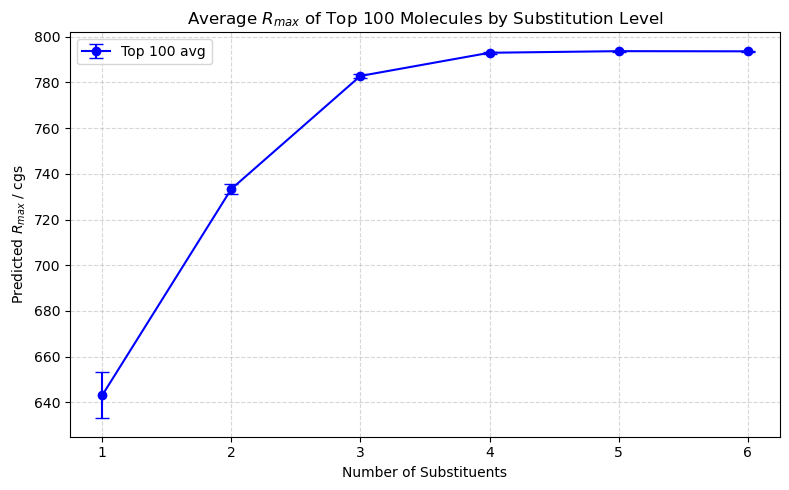

In [25]:
# Step 1: group predictions by number of halogen substitutions
substitution_levels = {
    1: mono_predictions,
    2: di_predictions,
    3: tri_predictions,
    4: tetra_predictions,
    5: penta_predictions,
    6: hexa_predictions
}

top_n = 100
avg_rmax = []
std_err_rmax = []
labels = []

for n_subs in sorted(substitution_levels.keys()):
    preds = substitution_levels[n_subs]

    # Sort by Rmax in descending order
    sorted_preds = sorted(preds, key=lambda x: x[1], reverse=True)

    # Take the top_n best molecules
    top_preds = sorted_preds[:top_n]

    # Calculate mean and standard error
    rmax_values = [rmax for _, rmax in top_preds]
    mean = np.mean(rmax_values)
    stderr = np.std(rmax_values, ddof=1) / np.sqrt(len(rmax_values))

    avg_rmax.append(mean)
    std_err_rmax.append(stderr)
    labels.append(n_subs)

# Step 2: plotting
plt.figure(figsize=(8, 5))
plt.errorbar(labels, avg_rmax, yerr=std_err_rmax, fmt='o-', color='blue', capsize=5, label='Top 100 avg')
plt.xlabel('Number of Substituents')
plt.ylabel('Predicted $R_{max}$ / cgs')
plt.title('Average $R_{max}$ of Top 100 Molecules by Substitution Level')
plt.xticks(labels)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


# Data analysis for hepta to hexadeca-halogenated [6]Helicenes
We are just going to predict 100 random molecules for each substituent from 7 to 16 due to the lack of power to predict all the molecules. This will lead us to an abrupt downfall of the Rmax mean curve from the 7th substituent because we cant make the mean value with the top 100 molecules.

In [27]:
import random

def generate_random_n_halogenated_helicenes(n_subs, n_samples=100, seed=42):
    random.seed(seed + n_subs)
    np.random.seed(seed + n_subs)
    seen = set()
    molecules = []
    attempts = 0
    max_attempts = n_samples * 100
    while len(molecules) < n_samples and attempts < max_attempts:
        pos_comb = random.sample(positions, n_subs)
        hal_comb = [random.choice(halogens) for _ in range(n_subs)]
        molecule = ['H'] * 16
        for pos, hal in zip(pos_comb, hal_comb):
            molecule[pos - 1] = hal
        mol_tuple = tuple(molecule)
        mol_rev = tuple(molecule[::-1])
        if mol_tuple in seen or mol_rev in seen:
            attempts += 1
            continue
        seen.add(mol_tuple)
        molecules.append(molecule)
        attempts += 1
    return molecules

# Store all predictions for each substituent count in separate variables
hepta_predictions = []
octa_predictions = []
nona_predictions = []
deca_predictions = []
undeca_predictions = []
dodeca_predictions = []
trideca_predictions = []
tetradeca_predictions = []
pentadeca_predictions = []
hexadeca_predictions = []

for n_subs in range(7, 17):
    random_mols = generate_random_n_halogenated_helicenes(n_subs=n_subs, n_samples=100, seed=42)
    encoded_batch = np.vstack([encode_molecule(mol, n_pos=16, n_atom_types=5) for mol in random_mols])
    pred_norm = best_model.predict(encoded_batch, verbose=0)
    pred = pred_norm * Rmax_abs_std + Rmax_abs_mean
    predictions = [(mol, float(val)) for mol, val in zip(random_mols, pred.ravel())]
    if n_subs == 7:
        hepta_predictions = predictions
    elif n_subs == 8:
        octa_predictions = predictions
    elif n_subs == 9:
        nona_predictions = predictions
    elif n_subs == 10:
        deca_predictions = predictions
    elif n_subs == 11:
        undeca_predictions = predictions
    elif n_subs == 12:
        dodeca_predictions = predictions
    elif n_subs == 13:
        trideca_predictions = predictions
    elif n_subs == 14:
        tetradeca_predictions = predictions
    elif n_subs == 15:
        pentadeca_predictions = predictions
    elif n_subs == 16:
        hexadeca_predictions = predictions
    print(f"Stored {len(predictions)} predictions for {n_subs}-halogenated [6]Helicenes.")

Stored 100 predictions for 7-halogenated [6]Helicenes.
Stored 100 predictions for 8-halogenated [6]Helicenes.
Stored 100 predictions for 9-halogenated [6]Helicenes.
Stored 100 predictions for 10-halogenated [6]Helicenes.
Stored 100 predictions for 11-halogenated [6]Helicenes.
Stored 100 predictions for 12-halogenated [6]Helicenes.
Stored 100 predictions for 13-halogenated [6]Helicenes.
Stored 100 predictions for 14-halogenated [6]Helicenes.
Stored 100 predictions for 15-halogenated [6]Helicenes.
Stored 100 predictions for 16-halogenated [6]Helicenes.


C:\Users\AlejandroN01\AppData\Local\Temp\ipykernel_253464\3821141492.py:47: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(labels[:6], avg_rmax[:6], 'o-', color='blue', label='Top 100 avg (1-6)', linestyle='-')
C:\Users\AlejandroN01\AppData\Local\Temp\ipykernel_253464\3821141492.py:50: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o--" (-> linestyle='--'). The keyword argument will take precedence.
  plt.plot(labels[6:], avg_rmax[6:], 'o--', color='blue', label='Top 100 avg (7-16)', linestyle='--')


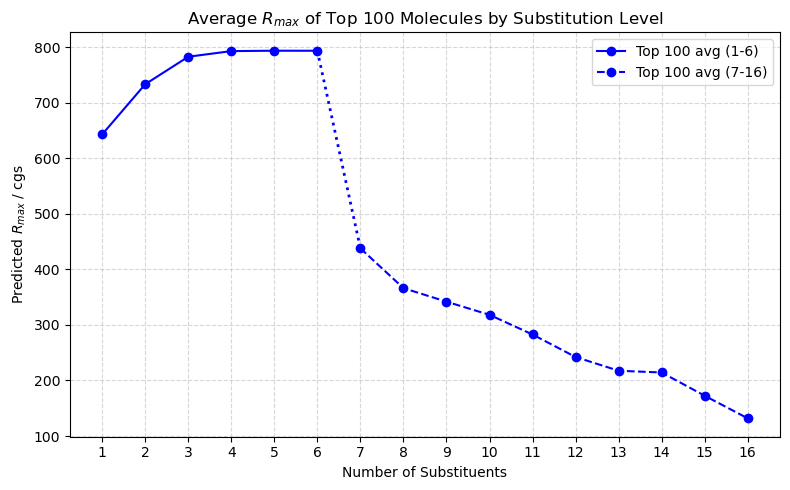

In [35]:
# Step 1: group predictions by number of halogen substitutions
substitution_levels = {
    1: mono_predictions,
    2: di_predictions,
    3: tri_predictions,
    4: tetra_predictions,
    5: penta_predictions,
    6: hexa_predictions,
    7: hepta_predictions,
    8: octa_predictions,
    9: nona_predictions,
    10: deca_predictions,
    11: undeca_predictions,
    12: dodeca_predictions,
    13: trideca_predictions,
    14: tetradeca_predictions,
    15: pentadeca_predictions,
    16: hexadeca_predictions
}

top_n = 100
avg_rmax = []
std_err_rmax = []
labels = []

for n_subs in sorted(substitution_levels.keys()):
    preds = substitution_levels[n_subs]

    # Sort by Rmax in descending order
    sorted_preds = sorted(preds, key=lambda x: x[1], reverse=True)

    # Take the top_n best molecules
    top_preds = sorted_preds[:top_n]

    # Calculate mean and standard error
    rmax_values = [rmax for _, rmax in top_preds]
    mean = np.mean(rmax_values)
    stderr = np.std(rmax_values, ddof=1) / np.sqrt(len(rmax_values))

    avg_rmax.append(mean)
    std_err_rmax.append(stderr)
    labels.append(n_subs)

plt.figure(figsize=(8, 5))

# Plot 1-6 substituents as a solid line
plt.plot(labels[:6], avg_rmax[:6], 'o-', color='blue', label='Top 100 avg (1-6)', linestyle='-')

# Plot 7-16 substituents as a dashed line
plt.plot(labels[6:], avg_rmax[6:], 'o--', color='blue', label='Top 100 avg (7-16)', linestyle='--')

# Connect point 6 to 7 with a line
plt.plot([labels[5], labels[6]], [avg_rmax[5], avg_rmax[6]], color='blue', linestyle=':', linewidth=2)

plt.xlabel('Number of Substituents')
plt.ylabel('Predicted $R_{max}$ / cgs')
plt.title('Average $R_{max}$ of Top 100 Molecules by Substitution Level')
plt.xticks(labels)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


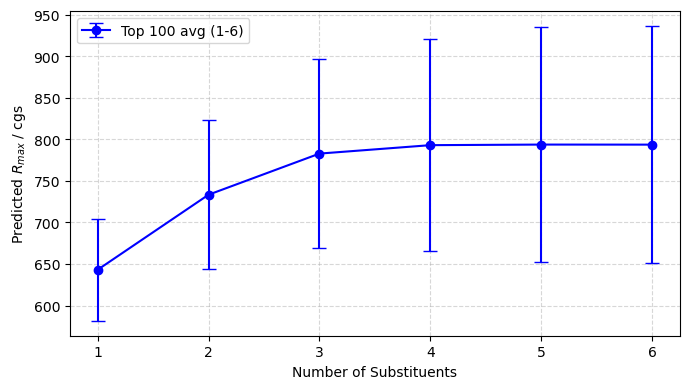

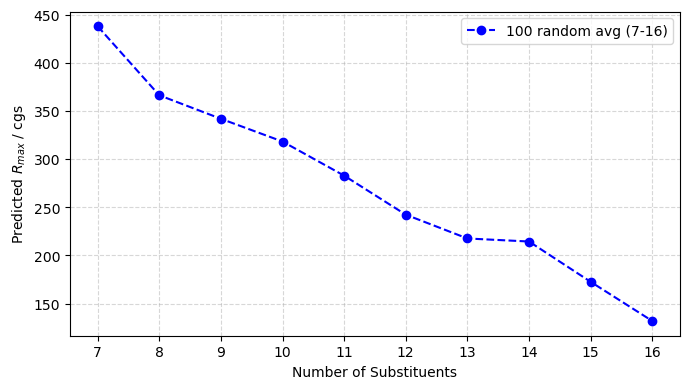

In [36]:
# Initialize accumulators
mean_rmax = []
intervals = []
labels = []

# 1-6 substituents: mean and quantile interval
for n_subs, preds in zip(range(1, 7), [mono_predictions, di_predictions, tri_predictions, tetra_predictions, penta_predictions, hexa_predictions]):
    top_preds = sorted(preds, key=lambda x: x[1], reverse=True)[:100]
    molecules = [mol for mol, _ in top_preds]
    encoded = np.vstack([encode_molecule(mol, n_pos=16, n_atom_types=5) for mol in molecules])
    lower_norm = model_lower.predict(encoded, verbose=0).ravel()
    upper_norm = model_upper.predict(encoded, verbose=0).ravel()
    lower = lower_norm * Rmax_abs_std + Rmax_abs_mean
    upper = upper_norm * Rmax_abs_std + Rmax_abs_mean
    interval = np.mean(upper - lower)
    mean = np.mean([rmax for _, rmax in top_preds])
    mean_rmax.append(mean)
    intervals.append(interval)
    labels.append(n_subs)

# 7-16 substituents: only mean, no error bar
mean_rmax_7_16 = []
labels_7_16 = []
for n_subs, preds in zip(
    range(7, 17),
    [hepta_predictions, octa_predictions, nona_predictions, deca_predictions, undeca_predictions,
     dodeca_predictions, trideca_predictions, tetradeca_predictions, pentadeca_predictions, hexadeca_predictions]
):
    top_preds = sorted(preds, key=lambda x: x[1], reverse=True)[:100]
    mean = np.mean([rmax for _, rmax in top_preds])
    mean_rmax_7_16.append(mean)
    labels_7_16.append(n_subs)

# Plot 1: 1-6 substituents
plt.figure(figsize=(7, 4))
plt.errorbar(labels, mean_rmax, yerr=intervals, fmt='o-', color='blue', capsize=5, label='Top 100 avg (1-6)')
plt.xlabel('Number of Substituents')
plt.ylabel('Predicted $R_{max}$ / cgs')
plt.xticks(labels)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

# Plot 2: 7-16 substituents
plt.figure(figsize=(7, 4))
plt.plot(labels_7_16, mean_rmax_7_16, 'o--', color='blue', label='100 random avg (7-16)')
plt.xlabel('Number of Substituents')
plt.ylabel('Predicted $R_{max}$ / cgs')
plt.xticks(labels_7_16)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

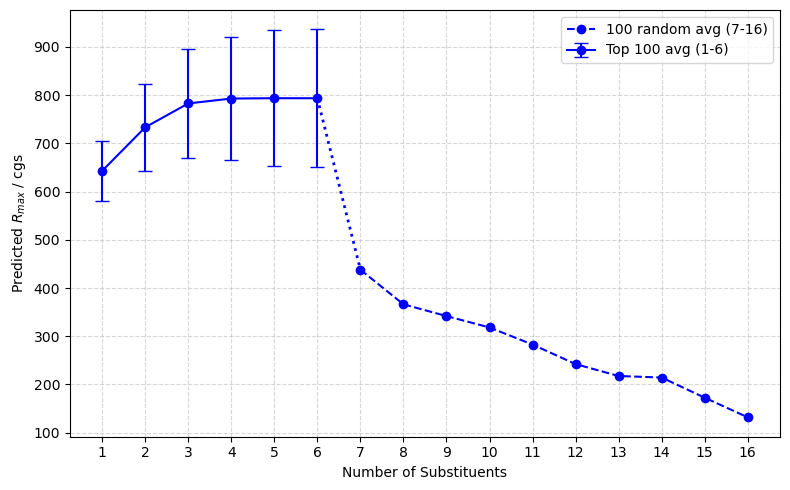

In [37]:
# --- Combined plot: Mean Rmax (top 100) with quantile interval as error bar for 1-6 substituents ---

mean_rmax = []
intervals = []
labels = []

# 1-6 substituents: mean and quantile interval
for n_subs, preds in zip(range(1, 7), [mono_predictions, di_predictions, tri_predictions, tetra_predictions, penta_predictions, hexa_predictions]):
    top_preds = sorted(preds, key=lambda x: x[1], reverse=True)[:100]
    molecules = [mol for mol, _ in top_preds]
    encoded = np.vstack([encode_molecule(mol, n_pos=16, n_atom_types=5) for mol in molecules])
    lower_norm = model_lower.predict(encoded, verbose=0).ravel()
    upper_norm = model_upper.predict(encoded, verbose=0).ravel()
    lower = lower_norm * Rmax_abs_std + Rmax_abs_mean
    upper = upper_norm * Rmax_abs_std + Rmax_abs_mean
    interval = np.mean(upper - lower)
    mean = np.mean([rmax for _, rmax in top_preds])
    mean_rmax.append(mean)
    intervals.append(interval)
    labels.append(n_subs)

# 7-16 substituents: only mean, no error bar
for n_subs, preds in zip(
    range(7, 17),
    [hepta_predictions, octa_predictions, nona_predictions, deca_predictions, undeca_predictions,
     dodeca_predictions, trideca_predictions, tetradeca_predictions, pentadeca_predictions, hexadeca_predictions]
):
    top_preds = sorted(preds, key=lambda x: x[1], reverse=True)[:100]
    mean = np.mean([rmax for _, rmax in top_preds])
    mean_rmax.append(mean)
    intervals.append(0)  # No error bar
    labels.append(n_subs)

plt.figure(figsize=(8, 5))
plt.errorbar(labels[:6], mean_rmax[:6], yerr=intervals[:6], fmt='o-', color='blue', capsize=5, label='Top 100 avg (1-6)')
plt.plot(labels[6:], mean_rmax[6:], 'o--', color='blue', label='100 random avg (7-16)')
# Connect point 6 to 7
plt.plot([labels[5], labels[6]], [mean_rmax[5], mean_rmax[6]], color='blue', linestyle=':', linewidth=2)
plt.xlabel('Number of Substituents')
plt.ylabel('Predicted $R_{max}$ / cgs')
plt.xticks(labels)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()